# Bitcoin Time Series Prediction with LSTM

#### Import necessary library needed for the model training

In [462]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import quandl
py.init_notebook_mode(connected=True)

#### Use Quandl api to get BTC/USD data from kraken exchange

In [486]:
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

#### View data info

In [493]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1380 entries, 2014-01-07 to 2017-10-17
Data columns (total 7 columns):
Open                 1380 non-null float64
High                 1380 non-null float64
Low                  1380 non-null float64
Close                1380 non-null float64
Volume (BTC)         1380 non-null float64
Volume (Currency)    1380 non-null float64
Weighted Price       1380 non-null float64
dtypes: float64(7)
memory usage: 126.2 KB


#### View data rows

In [488]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


#### Check latest date of data

In [489]:
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-10-13,5429.8,5854.4,5380.1,5640.0,9222.144339,5.178706e+07,5615.511555
2017-10-14,5626.7,5800.0,5556.1,5800.0,3019.946476,1.719205e+07,5692.831135
2017-10-15,5800.0,5840.4,5462.1,5680.0,4536.386215,2.545265e+07,5610.777658
2017-10-16,5673.2,5776.6,5550.0,5738.8,3134.620657,1.778638e+07,5674.172630
2017-10-17,5738.7,5759.9,5535.1,5577.8,3322.439554,1.869327e+07,5626.368279


#### Plot line graph base on `Weighted Price`

In [490]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

#### Fill value 0 data points on `Weighted Price` with NAN and then use ffill method to fill values

In [491]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

#### Plot new line graph again on `Weighted Price` with newly filled values

In [492]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

### Using `Weighted Price` as a feature to train the LSTM model 

#### Use MinMaxScaler to convert `Weighted Price` to range from 0 to 1

In [468]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Split 70% of data for training and 30% for testing

In [469]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

(965, 415)


#### Create function for creating dataset with look back

In [470]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Generate dataset for trainX, trainY, testX, testY

In [471]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

964
414


#### Reshape X for model training

In [473]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Running the LSTM model with 300 epochs

In [480]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 964 samples, validate on 414 samples
Epoch 1/300
2s - loss: 0.0318 - val_loss: 0.2634
Epoch 2/300
0s - loss: 0.0247 - val_loss: 0.2425
Epoch 3/300
0s - loss: 0.0240 - val_loss: 0.2334
Epoch 4/300
0s - loss: 0.0228 - val_loss: 0.2312
Epoch 5/300
0s - loss: 0.0221 - val_loss: 0.2284
Epoch 6/300
0s - loss: 0.0216 - val_loss: 0.2232
Epoch 7/300
0s - loss: 0.0212 - val_loss: 0.2170
Epoch 8/300
0s - loss: 0.0208 - val_loss: 0.2109
Epoch 9/300
0s - loss: 0.0203 - val_loss: 0.2052
Epoch 10/300
0s - loss: 0.0197 - val_loss: 0.1998
Epoch 11/300
0s - loss: 0.0192 - val_loss: 0.1939
Epoch 12/300
0s - loss: 0.0187 - val_loss: 0.1877
Epoch 13/300
0s - loss: 0.0182 - val_loss: 0.1812
Epoch 14/300
0s - loss: 0.0176 - val_loss: 0.1746
Epoch 15/300
0s - loss: 0.0171 - val_loss: 0.1676
Epoch 16/300
0s - loss: 0.0165 - val_loss: 0.1601
Epoch 17/300
0s - loss: 0.0158 - val_loss: 0.1524
Epoch 18/300
0s - loss: 0.0152 - val_loss: 0.1443
Epoch 19/300
0s - loss: 0.0145 - val_loss: 0.1357
Epoch 20/300


0s - loss: 0.0038 - val_loss: 0.0157
Epoch 164/300
0s - loss: 0.0038 - val_loss: 0.0118
Epoch 165/300
0s - loss: 0.0021 - val_loss: 0.0147
Epoch 166/300
0s - loss: 0.0018 - val_loss: 0.0175
Epoch 167/300
0s - loss: 0.0019 - val_loss: 0.0134
Epoch 168/300
0s - loss: 0.0017 - val_loss: 0.0119
Epoch 169/300
0s - loss: 0.0022 - val_loss: 0.0110
Epoch 170/300
0s - loss: 0.0035 - val_loss: 0.0127
Epoch 171/300
0s - loss: 0.0025 - val_loss: 0.0157
Epoch 172/300
0s - loss: 0.0019 - val_loss: 0.0205
Epoch 173/300
0s - loss: 0.0037 - val_loss: 0.0241
Epoch 174/300
0s - loss: 0.0028 - val_loss: 0.0127
Epoch 175/300
0s - loss: 0.0033 - val_loss: 0.0129
Epoch 176/300
0s - loss: 0.0035 - val_loss: 0.0120
Epoch 177/300
0s - loss: 0.0020 - val_loss: 0.0155
Epoch 178/300
0s - loss: 0.0017 - val_loss: 0.0163
Epoch 179/300
0s - loss: 0.0023 - val_loss: 0.0144
Epoch 180/300
0s - loss: 0.0018 - val_loss: 0.0112
Epoch 181/300
0s - loss: 0.0022 - val_loss: 0.0106
Epoch 182/300
0s - loss: 0.0035 - val_loss: 0

#### Plot line graph to show amount loss according the the epoch

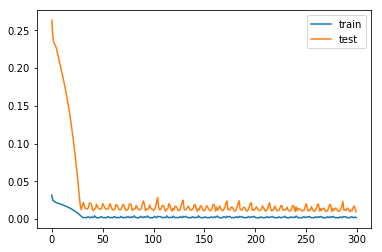

In [481]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Observation: 50 Epochs is enough

#### Make prediction using textX and plotting line graph against testY

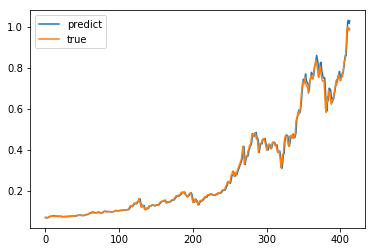

In [482]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [483]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

#### Plot line graph with Y as USD

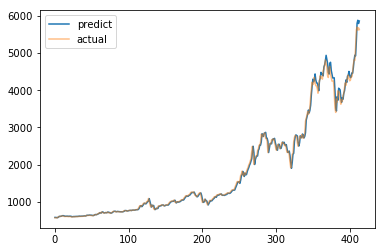

In [484]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Convert X to dates

In [494]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))
predictDates = data.tail(len(testX)).index

#### Plot predicted and actual line graph with X=dates, Y=USD

In [495]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])